In [88]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from starsml import compute_permutation_importance

# keras
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [3]:
df_good1 = pd.read_csv('data/likely_matches_plane.csv')

df_good = df_good1.query("prob >= 0.95 and separation <= 0.2")
df_bad = pd.read_csv('data/unlikely_matches_plane.csv')

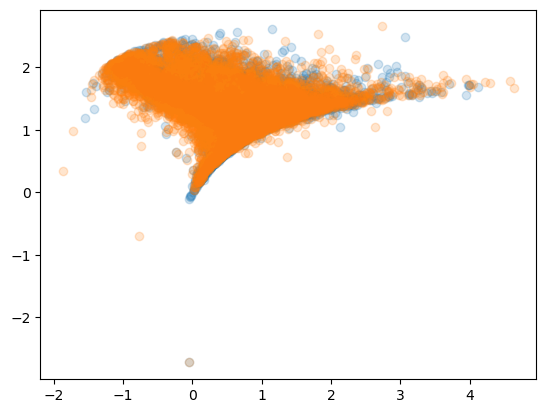

In [15]:
plt.scatter(df_good['bp_g'],df_good['g_rp'],alpha=0.2,)
plt.scatter(df_bad['bp_g'],df_bad['g_rp'],alpha=0.2)

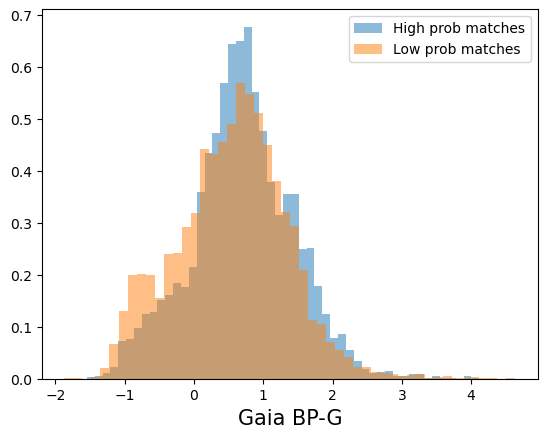

In [16]:
plt.hist(df_good['bp_g'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['bp_g'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-G',size=15)
plt.legend()
plt.savefig('figures/Gaia_BP_G.pdf',dpi=300)

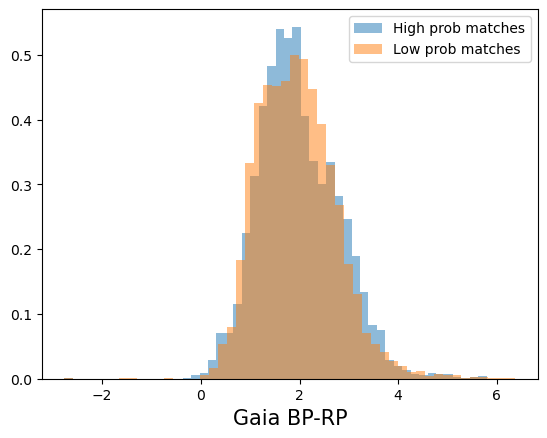

In [17]:
plt.hist(df_good['bp_rp'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['bp_rp'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-RP',size=15)
plt.legend()
plt.savefig('figures/Gaia_BP_RP.pdf',dpi=300)

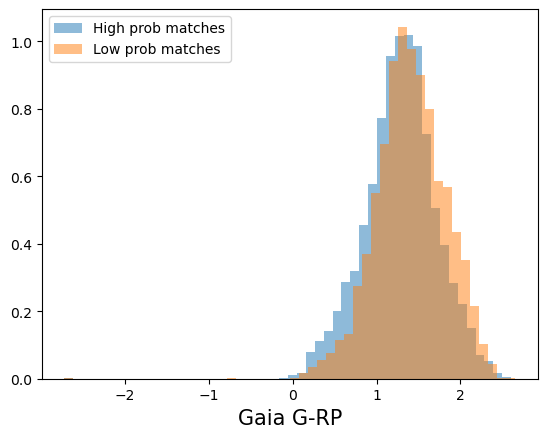

In [18]:
plt.hist(df_good['g_rp'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['g_rp'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia G-RP',size=15)
plt.legend()
plt.savefig('figures/Gaia_G_RP.pdf',dpi=300)

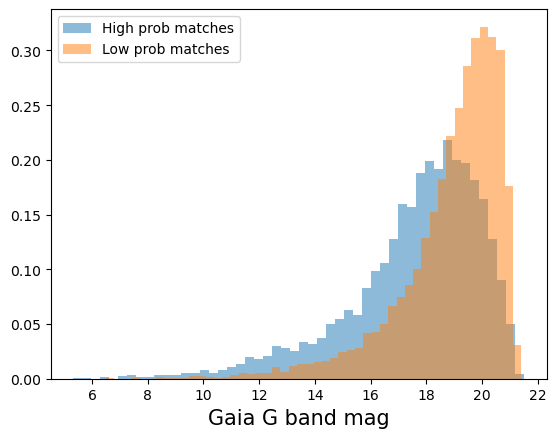

In [19]:
plt.hist(df_good['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_bad['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia G band mag',size=15)
#plt.xscale('log')
plt.legend()
plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

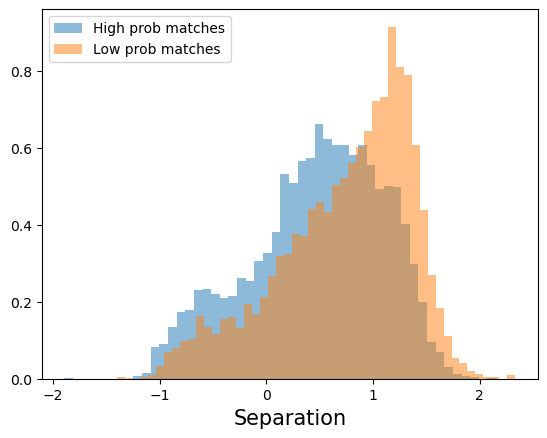

In [20]:
plt.hist(np.log10(100./df_good['phot_bp_mean_flux_over_error']),bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(np.log10(100./df_bad['phot_bp_mean_flux_over_error']),bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Separation',size=15)
#plt.xscale('log')
plt.legend()
plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

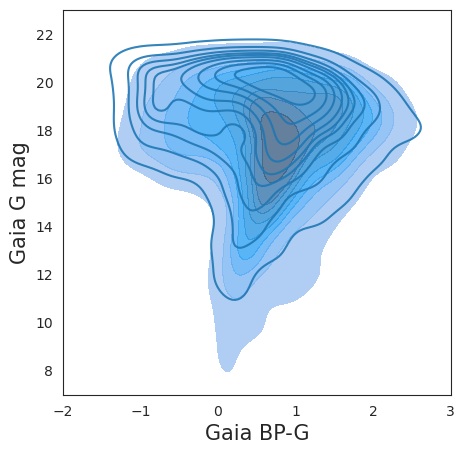

In [22]:
plt.rcParams['figure.figsize'] = 5, 5
sns.set_style("white")
sns.kdeplot(x=df_good.bp_g, y=df_good.phot_g_mean_mag, label = 'High prob matches',fill=True,alpha=0.8)
sns.kdeplot(x=df_bad.bp_g, y=df_bad.phot_g_mean_mag, label = 'Low prob matches',fill=False,alpha=0.9)
plt.xlim(-2,3)
plt.ylim(7,23)
plt.xlabel('Gaia BP-G',size=15)
plt.ylabel('Gaia G mag',size=15)
plt.savefig('figures/contour.pdf',dpi=300)

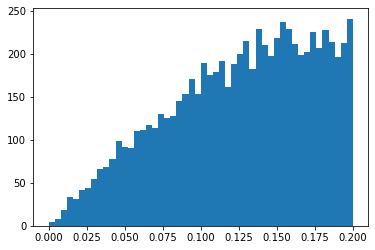

In [7]:
plt.hist(df_good['separation'],bins=50)
plt.show()

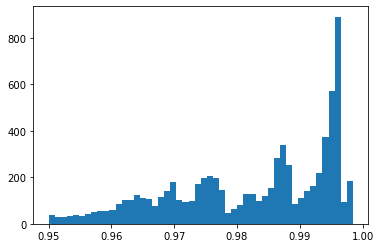

In [8]:
plt.hist(df_good['prob'],bins=50)
plt.show()

In [48]:

feature_names = [
    'separation', 
    'phot_g_mean_flux', 
    'phot_g_mean_flux_error', 
    'phot_g_mean_flux_over_error', 
    'phot_bp_mean_flux', 
    'phot_bp_mean_flux_error', 
    'phot_bp_mean_flux_over_error', 
    'phot_rp_mean_flux', 
    'phot_rp_mean_flux_error', 
    'phot_rp_mean_flux_over_error', 
    'bp_rp', 
    'bp_g', 
    'g_rp',
    'parallax', 
    'parallax_error',
    'parallax_over_error'
]

# List of features to skip for the log transformation
skip_log_features = ['separation', 'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_error', 'parallax_over_error']

def construct_dataset(df):
    transformed_features = [
        np.log10(df[feature].values) if feature not in skip_log_features else df[feature].values
        for feature in feature_names
    ]
    return StandardScaler().fit_transform(np.array(transformed_features))

X1 = construct_dataset(df_good)
X2 = construct_dataset(df_bad)

# Taking the log of the parallax. parallax/error for the error. Assume negative is nan.

In [103]:
X2.shape

(16, 12974)

In [56]:
X1_train = X1.T[0:5400]

In [57]:
shape(X1_train)

(5400, 16)

In [58]:
X1_test = X1.T[5400:] 

In [59]:
X2.shape

(16, 12974)

In [60]:
X2_train = X2.T[0:10000]

In [61]:
X2_test = X2.T[10000:]

In [62]:
shape(X2_test)

(2974, 16)

In [63]:
X_train = np.concatenate((X1_train,X2_train), axis=0)

In [64]:
X_test = np.concatenate((X1_test,X2_test), axis=0)

In [65]:
Y1_train = np.ones(5400)

In [66]:
Y1_test = np.ones(1928)

In [67]:
Y2_train = np.zeros(10000)

In [68]:
Y2_test = np.zeros(2974)

In [69]:
Y_train = np.concatenate((Y1_train,Y2_train), axis=0)

In [70]:
Y_test = np.concatenate((Y1_test,Y2_test), axis=0)

In [71]:
print(shape(X_train),shape(Y_train))

(15400, 16) (15400,)


In [72]:
arr = np.arange(15400)
np.random.shuffle(arr)
arr

array([15269,  9505, 15160, ...,  4729,  1862,  7683])

In [73]:
X_train = X_train[arr]

In [74]:
Y_train = Y_train[arr]

In [75]:
num_samples = X_train.shape[0]
nan_count_per_feature = np.isnan(X_train).sum(axis=0)

# Calculate the percentage for each feature
nan_percentage_per_feature = (nan_count_per_feature / num_samples) * 100

for i, percentage in enumerate(nan_percentage_per_feature):
    print(f"Percentage of NaN values in feature {feature_names[i]}: {percentage:.2f}%")


Percentage of NaN values in feature separation: 0.00%
Percentage of NaN values in feature phot_g_mean_flux: 0.00%
Percentage of NaN values in feature phot_g_mean_flux_error: 0.00%
Percentage of NaN values in feature phot_g_mean_flux_over_error: 0.00%
Percentage of NaN values in feature phot_bp_mean_flux: 26.89%
Percentage of NaN values in feature phot_bp_mean_flux_error: 26.89%
Percentage of NaN values in feature phot_bp_mean_flux_over_error: 26.89%
Percentage of NaN values in feature phot_rp_mean_flux: 26.92%
Percentage of NaN values in feature phot_rp_mean_flux_error: 26.92%
Percentage of NaN values in feature phot_rp_mean_flux_over_error: 26.92%
Percentage of NaN values in feature bp_rp: 26.96%
Percentage of NaN values in feature bp_g: 26.89%
Percentage of NaN values in feature g_rp: 26.92%
Percentage of NaN values in feature parallax: 22.80%
Percentage of NaN values in feature parallax_error: 22.80%
Percentage of NaN values in feature parallax_over_error: 22.80%


In [76]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
X_train = imp_mean.transform(X_train)

In [77]:
print(shape(X_test),shape(Y_test))

(4902, 16) (4902,)


In [78]:
arr = np.arange(4902)
np.random.shuffle(arr)
arr

array([3496, 2886,  944, ..., 4140, 1770, 2317])

In [79]:
X_test = X_test[arr]

In [80]:
Y_test = Y_test[arr]

In [81]:
imp_mean.fit(X_test)
X_test = imp_mean.transform(X_test)

#### Baseline Models

In [84]:
# See the efect of preprocessing, and parallax. Separately. 
# Model Building
clf = LogisticRegression(max_iter=10000)  # max_iter may need to be increased depending on data convergence
clf.fit(X_train, Y_train)

# Predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Precision:", precision_score(Y_test, y_pred))
print("Recall:", recall_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_prob))

#feature_importances = clf.coef_[0]
#for i, imp in enumerate(feature_importances):
#    print(f"{feature_names[i]}: Coefficient = {imp:.4f}")

Accuracy: 0.7549979600163199
Precision: 0.6809357889497263
Recall: 0.7095435684647303
F1 Score: 0.6949453898907797
AUC-ROC: 0.8222407127330362


In [85]:
# Model Building
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, Y_train)

# Predictions
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_prob = clf_rf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred_rf))
print("Precision:", precision_score(Y_test, y_pred_rf))
print("Recall:", recall_score(Y_test, y_pred_rf))
print("F1 Score:", f1_score(Y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_rf_prob))

Accuracy: 0.6352509179926561
Precision: 0.5319634703196348
Recall: 0.604253112033195
F1 Score: 0.5658086449732881
AUC-ROC: 0.7081331777200467


In [89]:
# Model Building
clf_svm = SVC(kernel='linear', probability=True, random_state=42)  # Using 'linear' kernel as a baseline. Probability is True for AUC-ROC.
clf_svm.fit(X_train, Y_train)

# Predictions
y_pred_svm = clf_svm.predict(X_test)
y_pred_svm_prob = clf_svm.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred_svm))
print("Precision:", precision_score(Y_test, y_pred_svm))
print("Recall:", recall_score(Y_test, y_pred_svm))
print("F1 Score:", f1_score(Y_test, y_pred_svm))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_svm_prob))

Accuracy: 0.744390044879641
Precision: 0.6464208242950108
Recall: 0.7728215767634855
F1 Score: 0.7039924403496338
AUC-ROC: 0.8266253589197666


#### NN

In [93]:
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(16,)))
network.add(layers.Dense(64, activation='relu', input_shape=(128,)))
network.add(layers.Dense(1, activation='sigmoid'))

In [94]:
Adagrad = optimizers.Adagrad(learning_rate=0.005)
network.compile(optimizer=Adagrad,
                loss='binary_crossentropy',
                metrics=['binary_accuracy'])
#optimizer.lr.set_value(0.02)

In [95]:
history = network.fit(X_train, Y_train, validation_split=0.2, epochs=200, batch_size=256)

Epoch 1/200
49/49 [==============================] - 4s 60ms/step - loss: 0.6568 - binary_accuracy: 0.6219 - val_loss: 0.6291 - val_binary_accuracy: 0.6601
Epoch 2/200
49/49 [==============================] - 2s 51ms/step - loss: 0.6282 - binary_accuracy: 0.6485 - val_loss: 0.6164 - val_binary_accuracy: 0.6799
Epoch 3/200
49/49 [==============================] - 3s 66ms/step - loss: 0.6192 - binary_accuracy: 0.6671 - val_loss: 0.6096 - val_binary_accuracy: 0.6776
Epoch 4/200
49/49 [==============================] - 3s 72ms/step - loss: 0.6135 - binary_accuracy: 0.6705 - val_loss: 0.6048 - val_binary_accuracy: 0.6792
Epoch 5/200
49/49 [==============================] - 3s 56ms/step - loss: 0.6087 - binary_accuracy: 0.6742 - val_loss: 0.6004 - val_binary_accuracy: 0.6808
Epoch 6/200
49/49 [==============================] - 3s 64ms/step - loss: 0.6047 - binary_accuracy: 0.6774 - val_loss: 0.5965 - val_binary_accuracy: 0.6799
Epoch 7/200
49/49 [==============================] - 3s 54ms/ste

In [96]:
network.save('models/model1.h5')

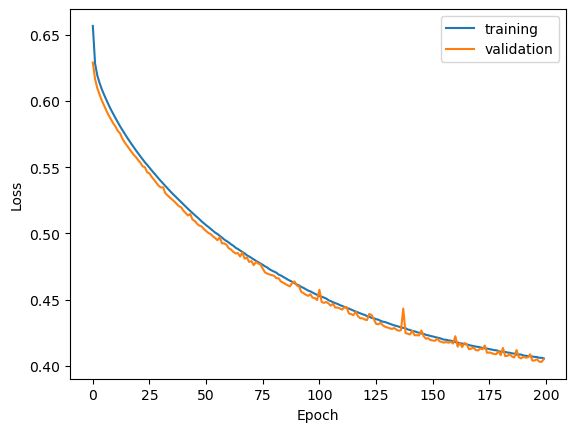

In [97]:
# 200, don't stop until overtfit. 
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('models/loss_nn1.pdf')

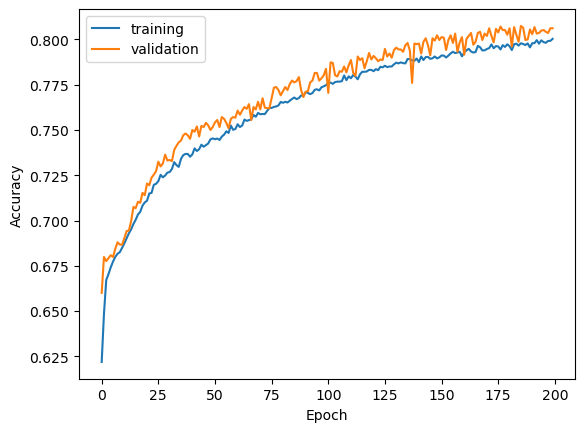

In [98]:
plt.plot(history.history['binary_accuracy'],label='training')
plt.plot(history.history['val_binary_accuracy'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/acc_nn1.pdf')

In [99]:
print('\n# Evaluate on test data')
results = network.evaluate(X_test, Y_test, batch_size=256)
print('test loss, test acc:', results)


# Evaluate on test data
20/20 [==============================] - 1s 31ms/step - loss: 0.5616 - binary_accuracy: 0.6942
test loss, test acc: [0.5616260170936584, 0.6942064166069031]


In [100]:
# Predict probabilities for the test set
y_pred_probs = network.predict(X_test).ravel()

# Convert probabilities to class labels (0 or 1) using a threshold, typically 0.5 for binary classification
y_pred_label = (y_pred_probs > 0.5).astype(int)

# Compute precision, recall, and F1 score
precision = precision_score(Y_test, y_pred_label)
recall = recall_score(Y_test, y_pred_label)
f1 = f1_score(Y_test, y_pred_label)

# Compute ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Display metrics
print('\n# Extended Evaluation Metrics')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC:', roc_auc)


154/154 [==============================] - 4s 28ms/step

# Extended Evaluation Metrics
Precision: 0.58911508101371
Recall: 0.7354771784232366
F1 Score: 0.6542099192618224
AUC: 0.75539539424668


In [106]:
# Compute permutation importance
importances = compute_permutation_importance(network, X_test, Y_test)

# Display the importances
for i, imp in enumerate(importances):
    print(f"{feature_names[i]}: Importance = {imp:.4f}")

154/154 [==============================] - 1s 5ms/step
separation: Importance = 0.1946
phot_g_mean_flux: Importance = 0.1059
phot_g_mean_flux_error: Importance = -0.0018
phot_g_mean_flux_over_error: Importance = 0.0045
phot_bp_mean_flux: Importance = 0.1028
phot_bp_mean_flux_error: Importance = 0.0080
phot_bp_mean_flux_over_error: Importance = -0.0139
phot_rp_mean_flux: Importance = -0.0063
phot_rp_mean_flux_error: Importance = 0.0082
phot_rp_mean_flux_over_error: Importance = -0.0059
bp_rp: Importance = 0.0014
bp_g: Importance = -0.0063
g_rp: Importance = 0.0143
